<a href="https://colab.research.google.com/github/onedayzero/food-sales-predictions/blob/main/food_sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Sales Predictions
-Clint Atterberry

-30 June 2022

# Setup

1. [x] Import libraries
2. [x] Read file into DataFrame

In [1]:
# Import Library pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')

In [2]:
# Get csv data from link for assignment
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ9hM0TmmxdZ3whTnYlhnTpQR0bVvUFganKildu6gE-u4P5hMtFyr0VXkgZ6b8IfBvC148lRAvmgAXU/pub?output=csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Pre-Processing
Pre-Process the data by
1. [x] Exploring the data by finding missing values and duplicate rows
2. [x] Make decisions on what to do following step 1
3. [x] Look for inconsistencies with the categorical data
4. [x] Look for numerical data that may be incorrectly entered by comparing it to the number summary of its column
5. [x] Make graphical displays to view the data in more detail

## Explore the Data

1. [x] Looking for and removing any duplicate rows
2. [x] Removing columns
3. [x] Finding out the data types and make any changes

### Are there duplicates? If so, drop any duplicates.

- There are no duplicate rows; therefore, there are no rows to drop.

In [3]:
# This will display the counts of the duplicated rows
df.duplicated().value_counts()

False    8523
dtype: int64

There are no duplicate rows.

### Dropping Columns

1. [x] Review column names
2. [x] Remove columns that are identifiers or not needed for analysis
3. [x] Review that columns were dropped

In [4]:
df.columns                                      # Review column names

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [5]:
# Remove unneeded columns
df.drop(columns=['Item_Identifier',             # Identifer Variable
                 'Outlet_Identifier',           # Identifer Variable
                 'Outlet_Establishment_Year'    # Not needed for analysis
                 ], 
        inplace=True)
df.columns                                      # Review columns were dropped

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

Success! All columns that needed to be dropped were dropped.

### Finding out the Data types

In [6]:
# Find data types of the columns
df.dtypes

Item_Weight             float64
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Outlet_Sales       float64
dtype: object

Data Types
___
1. Objects
- Item_Fat_Content
- Item_Type
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type
___
2. floats
- Item_Weight
- Item_Visibility
- Item_MRP
- Item_Outlet_Sales
___
3. Integers
- none
___
All data in the columns appear to have the appropriate type.

## Missing Values

1. [x] Search all columns for missing values and determine how to handle the missing values
2. [x] Execute decisions

### Missing Values

In [7]:
df.isna().sum()

Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

Results
___
1. There are 1463 missing values in 'Item_Weight'.
2. There are 2410 missing values in 'Outlet_Size'. 

In [8]:
# Looking at the number summary of 'Item_Weight'
df['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

Determination on Missing Values for 'Item_Weight'
___
Due to the 'Item_Weights' having such a potential for understanding the item prices, I will fill in all missing values with the mean score.
___
*I will fill in the rows that have the missing values with the mean value.*

In [9]:
# Looking at the different values in 'Outlet_Size'
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Determination on Missing Values for 'Outlet_Size'
___
Due to 'Outlet_Size' having so many missing values and because the data is ordinal, I will remove the missing rows because the outlet size may be helpful.
___
*I will remove the rows with missing values.

### Executing Plans for Dealing with Missing Values

1. [x] Fill in the rows that are missing data from 'Item_Weight' using the mean
2. [x] Drop rows that are missing data from 'Outlet_Size'

#### 'Item_Weight'

In [10]:
# Dropping rows with missing 'Item_Weight' data
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].mean())
df.isna().sum()

Item_Weight                0
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

Results
___
The rows were **successfully** filled in with the mean of the column.

#### 'Outlet_Size'

In [11]:
# Drop all rows with missing values
df = df.dropna(subset=['Outlet_Size'])
df.isna().sum()

Item_Weight             0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
dtype: int64

Results
___
The rows were **successfully** dropped from the DataFrame.

## Inconsistent Data

Explore all categorical columns for inconsitent values*
1. [x] Item_Fat_Content
2. [x] Item_Type
3. [x] Outlet_Location_type
4. [x] Outlet_Type

*An inconsistent value would be if there were a misspelling of a word or if there were different terms for the same thing in a categorical column. As well, looking at the mins and maxes of numeric columns for something odd or out-of-place.

### 'Item_Fat_Content'

In [12]:
df['Item_Fat_Content'].value_counts()

Low Fat    3641
Regular    2076
LF          233
reg          82
low fat      81
Name: Item_Fat_Content, dtype: int64

Analysis
___
1. Low Fat, LF, and low fat should all be "Low Fat"
2. Regular and reg should both be "Regular"

In [13]:
# This will replace the LF and low fat to both Low Fat, and reg to Regular

df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace=True)
df['Item_Fat_Content'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Low Fat    3955
Regular    2158
Name: Item_Fat_Content, dtype: int64

Success!

### 'Item_Type'

In [14]:
df['Item_Type'].value_counts()

Fruits and Vegetables    883
Snack Foods              868
Household                649
Frozen Foods             615
Dairy                    496
Canned                   471
Baking Goods             463
Health and Hygiene       367
Soft Drinks              312
Meat                     309
Breads                   179
Hard Drinks              148
Others                   123
Starchy Foods            105
Breakfast                 79
Seafood                   46
Name: Item_Type, dtype: int64

Analysis
___
No adjustments to the data in this column need to be made.

### 'Outlet_Location_Type'

In [15]:
df['Outlet_Location_Type'].value_counts()

Tier 3    2795
Tier 1    2388
Tier 2     930
Name: Outlet_Location_Type, dtype: int64

Analysis
___
No adjustments to the data in this column need to be made.

### 'Outlet_Type'

In [16]:
df['Outlet_Type'].value_counts()

Supermarket Type1    3722
Supermarket Type3     935
Supermarket Type2     928
Grocery Store         528
Name: Outlet_Type, dtype: int64

Analysis
___
No adjustments to the data in this column need to be made.

## Explore Numerical Data

For any numerical columns, obtain the summary statistics of each (min, max, mean)

1. [x] Item_Weight
2. [x] Item_Visibility
3. [x] Item_MRP
4. [x] Item_Outlet_Sales

### Summary Statistics for 'Item_Weight'
- min = 4.55
- max = 21.35
- mean = 12.86

In [17]:
# Item_Weight summary statistics
df['Item_Weight'].describe()

count    6113.000000
mean       12.888856
std         4.073798
min         4.555000
25%         9.800000
50%        12.857645
75%        15.700000
max        21.350000
Name: Item_Weight, dtype: float64

### Summary Statistics for 'Item_Visibility'
- min = 0
- max = 0.33
- mean = 0.07

In [18]:
# Item_Visibility summary statistics
df['Item_Visibility'].describe()

count    6113.000000
mean        0.064505
std         0.050092
min         0.000000
25%         0.026681
50%         0.052811
75%         0.092834
max         0.328391
Name: Item_Visibility, dtype: float64

### Summary Statistics for 'Item_MRP'
- min = 31.29
- max = 266.89
- mean = 140.99

In [19]:
# Item_MRP summary statistics
df['Item_MRP'].describe()

count    6113.000000
mean      141.256859
std        62.229701
min        31.290000
25%        94.012000
50%       143.178600
75%       185.892400
max       266.888400
Name: Item_MRP, dtype: float64

### Summary Statistics for 'Item_Outlet_Sales'
- min = 33.29
- max = 13,086.96
- mean = 2181.29

In [20]:
# Item_Outlet_Sales summary statistics
df['Item_Outlet_Sales'].describe()

count     6113.000000
mean      2322.688445
std       1741.592093
min         33.955800
25%        974.731200
50%       1928.156800
75%       3271.075400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

### Summary
___
All of the summary values appear to be reasonable values.

## Plot histograms of the following:
1. [x] Item Weight
2. [x] Item Visibility
3. [x] Item MRP
4. [x] Item Outlet Sales

### 'Item_Weight'

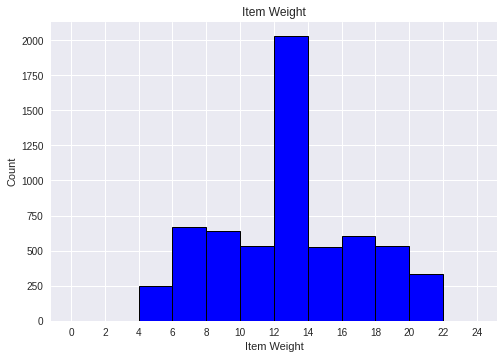

In [21]:
# Histogram for Item Weight

x = df['Item_Weight']
y = [0,2,4,6,8,10,12,14,16,18,20,22,24]

plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.title('Item Weight')
plt.xticks(y)
plt.show()

Analysis
___
Center - The item weight is centered around 13.

Shape - The item weight data is unimodal and symmetrical.

Spread - The item weight data spans from 4 to 22.

Anything Unusual - nothing is particularly unusual about this data.

### 'Item_Visibility'

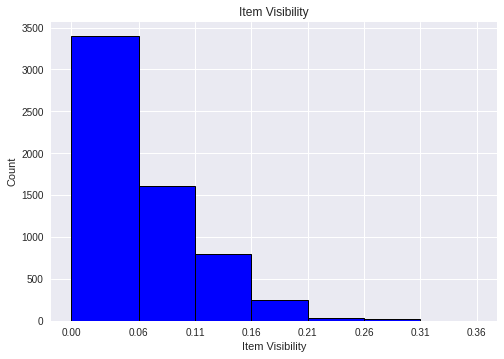

In [22]:
# Histogram for Item Visibility

x = df['Item_Visibility']
y = [0,0.06,0.11,0.16,0.21,0.26,0.31,0.36]

plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item Visibility')
plt.ylabel('Count')
plt.title('Item Visibility')
plt.xticks(y)
plt.show()

Because the histogram is skewed, I will look at the boxplot


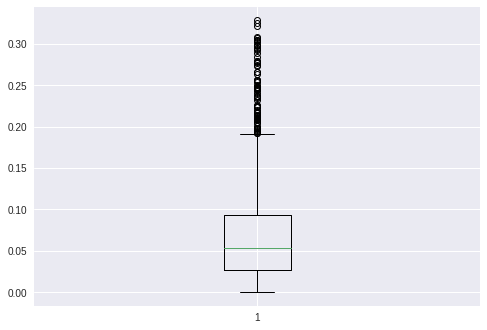

In [23]:
plt.boxplot(df['Item_Visibility']);

Analysis
___
Center - The item visibility data is centered is around 0.05.

Shape - The item visibility data is skewed to the right.

Spread - The item visibility data is primarily spread from 0 to 0.2. However, there are some outliers above 0.2 but below 0.35.

Anything Unusual - There are a number of outliers in this data set that are above the upper fence (which is around 0.2).

### 'Item_MRP'

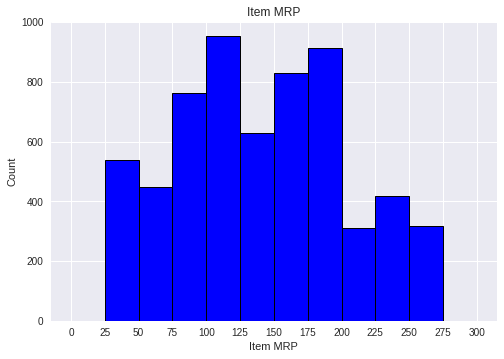

In [24]:
# Histogram for Item MRP

x = df['Item_MRP']
y = [0,25,50,75,100,125,150,175,200,225,250,275,300]
     
plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item MRP')
plt.ylabel('Count')
plt.title('Item MRP')
plt.xticks(y)
plt.show()

Analysis
___
Center - The center of the Item MRP data is around 150.

Shape - The Item MRP data is fairly unimodal and symmetrical.

Spread - The Item MRP data spans from 25 to 275.

Anything Unusual - The data is fairly unimodal; however, the data could be interpretted to actually be multimodal. This data might be looked at in 3 sections, 25-125, 125-200, and 200-275. More data would need to be collected to make a better determination or the data should be **experimented** with.

### 'Item_Visibility'

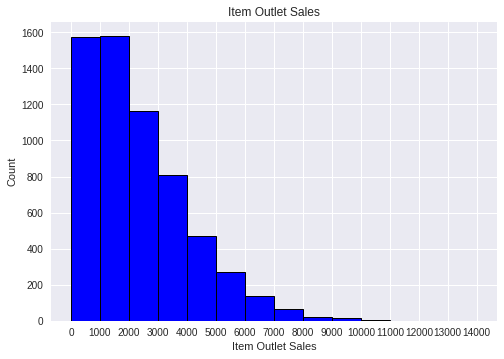

In [25]:
# Histogram for Item Visibility

x = df['Item_Outlet_Sales']
y = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000]

plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item Outlet Sales')
plt.ylabel('Count')
plt.title('Item Outlet Sales')
plt.xticks(y)
plt.show()

### Because the histogram is skewed, I will look at the boxplot

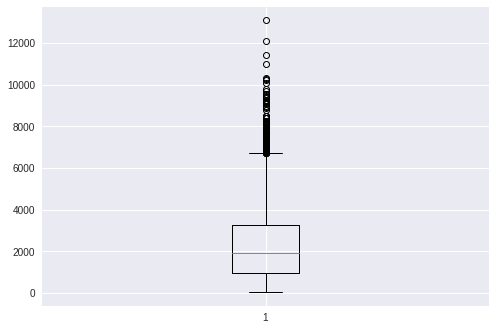

In [26]:
plt.boxplot(df['Item_Outlet_Sales']);

Analysis
___
Center - The item outlet sales data is centered around the value of 2000.

Shape - The item outlet sales data is skewed to the right.

Spread - The item outlet sales data spreads from 0 to a little over 6000. However, outliers can be found all the way out past 12,000.

Anything Unusual - The data is very skewed to the right and has a lot of outliers that go out to **twice the distance** from the *minimum value* to the *upper fence*.

### Heat Map of Data

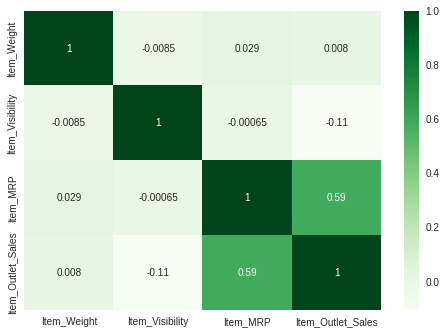

In [27]:
# Creating a heat map of the data
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True);

Analysis
___
The data seems to have almost 0 correlation with the exception of the item MRP and the item outlet sales (r = 0.57). More investigation into all of the data sets should be considered, some data might have more of a correlation if spliced into different sections.

*** 'Item_Outlet_Sales'

In [28]:
## functionize the above plot and call it plot_dist
def plot_dist(data, x='Item_Outlet_Sales', figsize=(10,5)):
  ## Make a larger fig/ax before plotting
  fig, ax = plt.subplots(figsize=figsize)

  ## Plot histogram
  sns.histplot(data=df, x=x, ax=ax)
  ax.set(title='Item Outlet Sales Data');

  ## Annotate mean and median
  mean_price = df[x].mean()
  ax.axvline(mean_price, color='slategray', ls=':', lw=3,
            label=f'Mean Price = ${mean_price:,.2f}');

  med_price = df[x].median()
  ax.axvline(med_price, color='skyblue', ls=':', lw=3,
            label=f'Median Price = ${med_price:,.2f}');

  ax.legend();
  return fig, ax

### 'Item_Outlet_Sales'

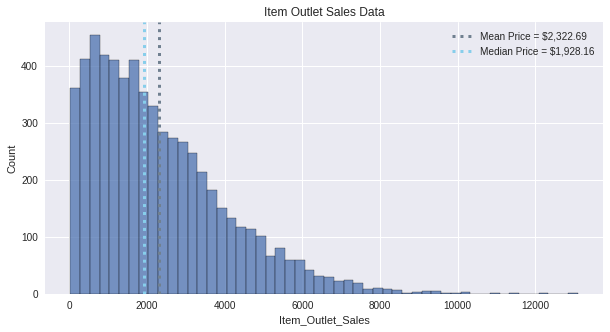

In [29]:
fig, ax = plot_dist(df)

Analysis
___
Because this data will be our **target**, I will be more thorough with this display.

The mean and median have a *significant* gap. The mean outlet sales are almost $400 **more than** the median outlet sales. This is due to the data being skewed to the right. When exploring this data more, the median will be the best choice for the middle point of the data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


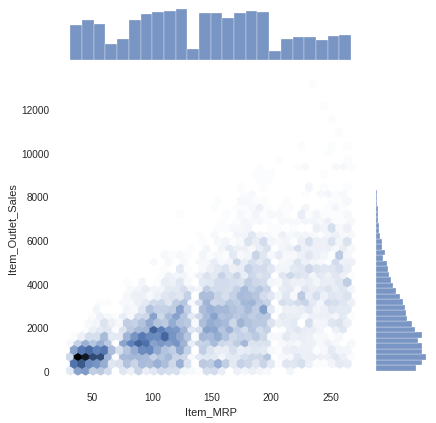

In [30]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
# as reference

with sns.axes_style('white'):
    sns.jointplot(df['Item_MRP'], df['Item_Outlet_Sales'], data=df, kind='hex');

Analysis
___
This graph shows that there are 4 clusters of data within 'Item_Outlet_Sales'. It appears that there are 4 groups:
1. less than 75 MRP
2. 75 - 125 MRP
3. 125 - 200 MRP
4. greater than 200 MRP

*All values are estimated*

### Outlet Type Comparison

In [31]:
df['Outlet_Type'].value_counts()

Supermarket Type1    3722
Supermarket Type3     935
Supermarket Type2     928
Grocery Store         528
Name: Outlet_Type, dtype: int64

The most common type of outlet is Supermarket Type 1. The other outlet types are all fairly similar in quantity.

# Prep for Machine Learning

## Explore the data
1. [x] Review the data
2. [x] Identify the **Target** and **Features**


In [32]:
df_ml = df
df_ml

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
4,8.930,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052
5,10.395,Regular,0.000000,Baking Goods,51.4008,Medium,Tier 3,Supermarket Type2,556.6088
...,...,...,...,...,...,...,...,...,...
8517,20.750,Regular,0.083607,Frozen Foods,178.8318,Small,Tier 1,Supermarket Type1,3608.6360
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,High,Tier 3,Supermarket Type1,2778.3834
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,Medium,Tier 3,Supermarket Type2,1845.5976


In [33]:
# Look at the info from the data
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6113 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           6113 non-null   float64
 1   Item_Fat_Content      6113 non-null   object 
 2   Item_Visibility       6113 non-null   float64
 3   Item_Type             6113 non-null   object 
 4   Item_MRP              6113 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  6113 non-null   object 
 7   Outlet_Type           6113 non-null   object 
 8   Item_Outlet_Sales     6113 non-null   float64
dtypes: float64(4), object(5)
memory usage: 477.6+ KB


## Features
Identify the 3 types of Features
1. [x] Numerical
2. [x] Oridanl
3. [x] Nominal


___
**Numerical**
___
1. Item_Weight
2. Item_Visibility
3. Item_MRP
4. Item_Outlet_Sales
___
**Ordinal**
___
1. Item_Fat_Content
2. Outlet_Size
3. Outlet_Location_Type
___
**Nominal**
___
1. Item_Type
2. Outlet_Type

In [34]:
# Review all values in object columns
for col in df_ml.select_dtypes(include='object').columns:
  display(df_ml[col].value_counts())
  print('\n')

Low Fat    3955
Regular    2158
Name: Item_Fat_Content, dtype: int64

Fruits and Vegetables    883
Snack Foods              868
Household                649
Frozen Foods             615
Dairy                    496
Canned                   471
Baking Goods             463
Health and Hygiene       367
Soft Drinks              312
Meat                     309
Breads                   179
Hard Drinks              148
Others                   123
Starchy Foods            105
Breakfast                 79
Seafood                   46
Name: Item_Type, dtype: int64

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Tier 3    2795
Tier 1    2388
Tier 2     930
Name: Outlet_Location_Type, dtype: int64

Supermarket Type1    3722
Supermarket Type3     935
Supermarket Type2     928
Grocery Store         528
Name: Outlet_Type, dtype: int64

## Oridinal Encoding
Perform Ordinal Encoding on the following 3 features:
1. [x] Item_Fat_Content
2. [x] Outlet_Size
3. [x] Outlet_Location_Type

In [35]:
# Ordinal Encoding 'Item_Fat_Content'
replacement_dictionary = {'Low Fat':0, 'Regular':1}
df_ml['Item_Fat_Content'].replace(replacement_dictionary, inplace=True)
print(df_ml['Item_Fat_Content'])

# Ordinal Encoding 'Outlet_Size'
replacement_dictionary = {'Small':0, 'Medium':1, 'High':2}
df_ml['Outlet_Size'].replace(replacement_dictionary, inplace=True)
print(df_ml['Outlet_Size'])

# Ordinal Encoding 'Outlet_Location_Type'
replacement_dictionary = {'Tier 1':0, 'Tier 2':1, 'Tier 3':2}
df_ml['Outlet_Location_Type'].replace(replacement_dictionary, inplace=True)
print(df_ml['Outlet_Location_Type'])

0       0
1       1
2       0
4       0
5       1
       ..
8517    1
8518    0
8520    0
8521    1
8522    0
Name: Item_Fat_Content, Length: 6113, dtype: int64
0       1
1       1
2       1
4       2
5       1
       ..
8517    0
8518    2
8520    0
8521    1
8522    0
Name: Outlet_Size, Length: 6113, dtype: int64
0       0
1       2
2       0
4       2
5       2
       ..
8517    0
8518    2
8520    1
8521    2
8522    0
Name: Outlet_Location_Type, Length: 6113, dtype: int64


## Create Instances

In [36]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [37]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

## Train Test Split Data
1. [x] Determine the Features (X matrix)
2. [x] Determine the Target (y array)

In [38]:
# split X and y, you are predicting price
X = df_ml.drop(columns=['Item_Outlet_Sales'])
y = df_ml['Item_Outlet_Sales']

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [39]:
# create a subset of data for only categorical columns
train_cat_data = X_train[cat_selector(X_train)]
test_cat_data = X_test[cat_selector(X_test)]
train_cat_data                                      # To review data selection

,Item_Type,Outlet_Type
1190,Dairy,Supermarket Type2
2279,Fruits and Vegetables,Supermarket Type1
3526,Seafood,Supermarket Type1
4023,Household,Supermarket Type1
5687,Snack Foods,Supermarket Type1
...,...,...
5281,Health and Hygiene,Supermarket Type3
7254,Canned,Supermarket Type1
7307,Dairy,Supermarket Type1
7533,Snack Foods,Supermarket Type1


In [40]:
# fit the OneHotEncoder on the training data
ohe.fit(train_cat_data)
#transform both the training and the testing data
train_ohe = ohe.transform(train_cat_data)
test_ohe = ohe.transform(test_cat_data)
train_ohe

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

## Concatenate the One-hot Encoded Categorical Features with the Numeric Features

In [41]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [42]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [43]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ad18eb110>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ad18eb050>)])

In [44]:
# fit on train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ad18eb110>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ad18eb050>)])

In [45]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [46]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (4584, 26)




array([[-1.59842795, -0.74212145, -0.21314897, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.29952735, -0.74212145, -0.87321392, ...,  1.        ,
         0.        ,  0.        ],
       [-0.08104583, -0.74212145, -0.16357935, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.43706591, -0.74212145,  1.11285892, ...,  1.        ,
         0.        ,  0.        ],
       [-0.8421922 ,  1.34748834, -1.06937873, ...,  1.        ,
         0.        ,  0.        ],
       [-1.15278903, -0.74212145, -0.99797205, ...,  1.        ,
         0.        ,  0.        ]])

Now all of our transformations are complete and we are ready for modeling! We can see that the numeric columns have been scaled and the categorical columns have been encoded as numbers. All of the columns are now listed as numeric columns and are ready for machine learning. Mission accomplished!

# Regression Metrics
1. [x] Build a linear regression model to predict sales
2. [x] Build a regression tree model to predict sales
3. [x] Determine which model to implement

## Linear Regression Model
1. [x] Build a Linear Regression Model
2. [x] Evaluate the performance of your model based on R-Squared
3. [x] Evaluate the performance of your model based on RMSE

### Build the Linear Regression Model

In [47]:
# Instance for Linear Regression Models
reg = LinearRegression()

# Model Pipeline
reg_pipe = make_pipeline(scaler, reg)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("linear regression", reg_pipe)])

# Fit the data to the Pipeline
clf.fit(X_train,y_train)

# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
# as reference

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ad18eb110>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ad18eb050>)])),
                ('linear regression',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('linearregression', LinearRegression())]))])

### Evaluate the performance of your model based on R-Squared

### Evaluate the performance of your model based on RMSE


In [48]:
# Create Predicions
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# View the R-Squared results
print(f'Training model R-Squared: {clf.score(X_train, y_train).round(3)}')
print(f'Testing model R-Squared: {clf.score(X_test, y_test).round(3)}')

# Perform Calculations for the Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(np.mean(np.abs(train_pred - y_train)**2))
rmse_test = np.sqrt(np.mean(np.abs(test_pred - y_test)**2))

print(f'Linear Model Training RMSE: {rmse_train.round(3)}')
print(f'Linear Model Testing RMSE: {rmse_test.round(3)}')

Training model R-Squared: 0.557
Testing model R-Squared: 0.569
Linear Model Training RMSE: 1162.415
Linear Model Testing RMSE: 1133.186


## Regression Tree Model

1. [x] Create a Regression Tree
2. [x] Compare the the performance of your model based on R-Squared
3. [x] Compare the the performance of your model based on RMSE

### Create a Regression Tree

In [49]:
# Make an instance
dec_tree = DecisionTreeRegressor(random_state = 42)

# Fit the data
dec_tree.fit(X_train_processed, y_train)

# Predict the target values
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

# Evaluate the model
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score.round(3))
print(test_score.round(3))

1.0
0.175


In [50]:
# What was the depth of our default tree and how many nodes are there?
print(f'The depth of this decision tree is {dec_tree.get_depth()}.')
print(f'There are {dec_tree.get_n_leaves()} amount of nodes.')

The depth of this decision tree is 30.
There are 4531 amount of nodes.


In [51]:
# List of values to try for max_depth:
depths = list(range(2, dec_tree.get_depth())) # will try every value between 2 and 36
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score = dec_tree.score(X_train_processed, y_train)
    test_score = dec_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

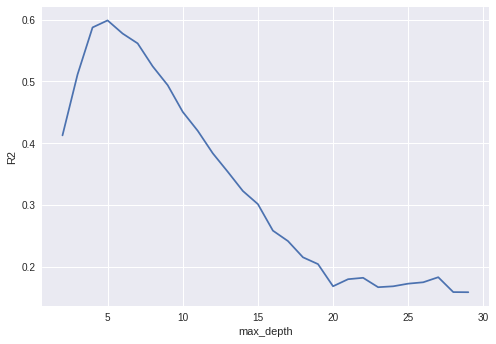

In [52]:
# Visualize which max_depth leads to the highest r2 score
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [53]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.598889,0.592931
4,0.587502,0.571875
6,0.577618,0.608476
7,0.561695,0.626305
8,0.52455,0.651274


In [54]:
# Create a variable for the optimal value
opt_val = sorted_scores['Test Score'].index[0]

# Let's run the model with our optimized value for max_depth
dec_tree_opt = DecisionTreeRegressor(max_depth = opt_val, random_state = 42)
dec_tree_opt.fit(X_train_processed, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [55]:
# I will be using the dec_tree_opt as our pipeline
train_pred = dec_tree_opt.predict(X_train_processed)
test_pred = dec_tree_opt.predict(X_test_processed)

# R2
r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, test_pred)

print(f'Regression Tree Model Training R-Squared: {r2_train.round(3)}')
print(f'Regression Tree Model Testing R-Squared: {r2_test.round(3)}')

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'Regression Tree Model Training RMSE: {rmse_train.round(3)}')
print(f'Regression Tree Model Testing RMSE: {rmse_test.round(3)}')

Regression Tree Model Training R-Squared: 0.593
Regression Tree Model Testing R-Squared: 0.599
Regression Tree Model Training RMSE: 1114.37
Regression Tree Model Testing RMSE: 1093.013


# Comparing the Models

|Model|R2 Test|RMSE Test|
|--|--|--|
|Linear Regression|0.569|1133.186|
|Regression Tree|0.599|1093.013|
|_delta_|0.030|-40.173|

# Summary

I would recommend the Regression Tree model. Here are my 2 reasons why:
1. The Regression tree has a slightly stronger R-Squared value. The value is about 0.03 higher, which is the difference of 56.9% to 59.9%.
2. The Root Mean Squared Error of the Regression Tree is also slightly lower, about 3% lower.